In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juileejoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("../../PythonDatasets/books2.csv")

In [14]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,cleaned
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,harry potter half blood prince harry potter 6
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,harry potter order phoenix harry potter 5
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,harry potter chamber secrets harry potter 2
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,harry potter prisoner azkaban harry potter 3
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,harry potter boxed set books 1 5 harry potter 1 5


In [5]:
#Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['title'].apply(_removeNonAscii)

df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)

In [6]:
#splitting the description into words

corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [7]:
print(corpus)

[['harry', 'potter', 'half', 'blood', 'prince', 'harry', 'potter', '6'], ['harry', 'potter', 'order', 'phoenix', 'harry', 'potter', '5'], ['harry', 'potter', 'chamber', 'secrets', 'harry', 'potter', '2'], ['harry', 'potter', 'prisoner', 'azkaban', 'harry', 'potter', '3'], ['harry', 'potter', 'boxed', 'set', 'books', '1', '5', 'harry', 'potter', '1', '5'], ['unauthorized', 'harry', 'potter', 'book', 'seven', 'news', 'half', 'blood', 'prince', 'analysis', 'speculation'], ['harry', 'potter', 'collection', 'harry', 'potter', '1', '6'], ['ultimate', 'hitchhiker', 's', 'guide', 'five', 'complete', 'novels', 'one', 'story', 'hitchhiker', 's', 'guide', 'galaxy', '1', '5'], ['ultimate', 'hitchhiker', 's', 'guide', 'galaxy', 'hitchhiker', 's', 'guide', 'galaxy', '1', '5'], ['hitchhiker', 's', 'guide', 'galaxy', 'hitchhiker', 's', 'guide', 'galaxy', '1'], ['hitchhiker', 's', 'guide', 'galaxy', 'hitchhiker', 's', 'guide', 'galaxy', '1'], ['ultimate', 'hitchhiker', 's', 'guide', 'hitchhiker', 's', 

In [8]:
EMBEDDING_FILE = '../../PythonDatasets/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Training our corpus with Google Pretrained Model

google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

(0, 0)

In [9]:
# Generate the average word2vec for the each book description

def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model[word]
                else:
                    avgword2vec = avgword2vec + google_model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)


In [18]:
#this is for existing
def recommendations(title):
    
    # Calling the function vectors

    vectors(df)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)
    # taking the title and book image link and store in new data frame called books
    books = df[['title']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get('http://www.w3schools.com/css/trolltunga.jpg')
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

<ipython-input-9-90dd20a731cb>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = google_model[word]
<ipython-input-9-90dd20a731cb>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = avgword2vec + google_model[word]


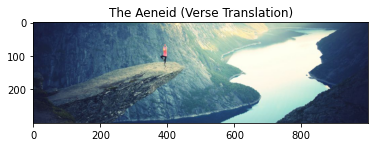

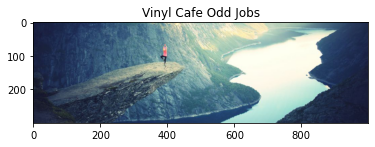

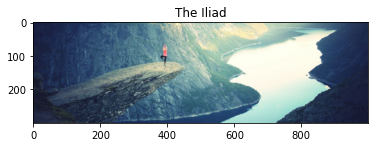

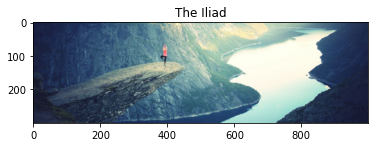

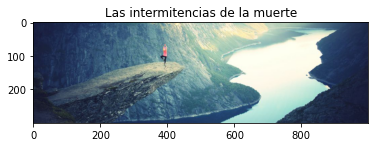

In [25]:
recommendations("War and the Iliad")

In [ ]:
#Just run this for keywords based recommendation
text = "woods peace"
vectors(df)
avgword2vec = None
embeddings = []
count = 0
for word in text.split():
    if word in google_model.wv.vocab:
        count += 1
        if avgword2vec is None:
            avgword2vec = google_model[word]
        else:
            avgword2vec = avgword2vec + google_model[word]
if avgword2vec is not None:
    avgword2vec = avgword2vec / count
embeddings.append(avgword2vec)
cosine_similarities = cosine_similarity(word_embeddings, embeddings)
books = df[['title']]
    #Reverse mapping of the index
indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
sim_scores = list(enumerate(cosine_similarities))
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
sim_scores = sim_scores[1:6]
print(sim_scores)
book_indices = [i[0] for i in sim_scores]
recommend = books.iloc[book_indices]
for index, row in recommend.iterrows():
    response = requests.get('http://www.w3schools.com/css/trolltunga.jpg')
    img = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(img)
    plt.title(row['title'])